# Описание

Необходимо разработать модель, предсказывающую уровнь английского языка субтиров.

# Загрузка и подготовка данных

Импортируем нужные библиотеки

In [1]:
import os
from os import listdir
import zipfile
import numpy as np
import pandas as pd
import pysrt
from chardet.universaldetector import UniversalDetector
import spacy
import re
import string
from bs4 import BeautifulSoup
import nltk
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Загрузим данные

In [2]:
NLP = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [3]:
with zipfile.ZipFile('English_scores.zip') as data:
    data.extractall('datasets')

In [4]:
sub_path = 'datasets/Subtitles_all'

In [5]:
sub_dirs = [d for d in os.listdir(sub_path) if os.path.isdir('/'.join([sub_path, d]))]
sub_dirs

['B2', 'A2', 'C1', 'B1', 'Subtitles']

In [6]:
df = pd.DataFrame()
for d in sub_dirs:
    path_to_movie = '/'.join([sub_path, d])
    movies = [f for f in listdir(path_to_movie) if os.path.isfile('/'.join([path_to_movie, f]))]
    m = {}
    m['level'] = [d] * len(movies)
    m['movies'] = movies
    m['path'] = [path_to_movie] * len(movies)
    df = pd.concat([df, pd.DataFrame(m)])
df = df.reset_index(drop = True)
df['srt'] = df['movies'].apply(lambda x: x.endswith('.srt'))
df['path'] = df['path'] + '/' + df['movies']

In [7]:
df.head()

,level,movies,path,srt
0,B2,"Crown, The S01E01 - Wolferton Splash.en.srt","datasets/Subtitles_all/B2/Crown, The S01E01 - ...",True
1,B2,Suits.Episode 1- Denial.srt,datasets/Subtitles_all/B2/Suits.Episode 1- Den...,True
2,B2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,datasets/Subtitles_all/B2/Crazy4TV.com - Suits...,True
3,B2,Suits.S02E08.HDTV.x264-EVOLVE.srt,datasets/Subtitles_all/B2/Suits.S02E08.HDTV.x2...,True
4,B2,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STR...,datasets/Subtitles_all/B2/Virgin.River.S01E07....,True


Проверим все ли файлы имеют формат субтитров

In [8]:
df.shape[0]

279

In [9]:
df['srt'].sum()

278

In [10]:
df.query('srt != True')

,level,movies,path,srt
175,Subtitles,.DS_Store,datasets/Subtitles_all/Subtitles/.DS_Store,False


In [11]:
df = df.drop(df.query('srt != True').index[0])

In [12]:
df.shape[0]

278

In [13]:
df['srt'].sum()

278

Одна строка содержала данные не являющиеся субтитрами. Удалили эту строку. Далее удалим более не нужный столбец srt. 

Из названий фильмов удалим расширение.

Посмотрим какие категории фильмов получились.

In [14]:
df = df.drop('srt', axis = 1)
df = df.reset_index(drop=True)

In [15]:
df['movies'] = df['movies'].apply(lambda x: x[:-4])

In [16]:
df.head()

,level,movies,path
0,B2,"Crown, The S01E01 - Wolferton Splash.en","datasets/Subtitles_all/B2/Crown, The S01E01 - ..."
1,B2,Suits.Episode 1- Denial,datasets/Subtitles_all/B2/Suits.Episode 1- Den...
2,B2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,datasets/Subtitles_all/B2/Crazy4TV.com - Suits...
3,B2,Suits.S02E08.HDTV.x264-EVOLVE,datasets/Subtitles_all/B2/Suits.S02E08.HDTV.x2...
4,B2,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE,datasets/Subtitles_all/B2/Virgin.River.S01E07....


In [17]:
df['level'].unique()

array(['B2', 'A2', 'C1', 'B1', 'Subtitles'], dtype=object)

Видим что среди категорий есть 'Subtitles'.

Загрузим дополнительные данные из имеющегося эксель файла.

In [18]:
movies_labels = pd.read_excel('datasets/movies_labels.xlsx')
movies_labels.head()

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


In [19]:
movies_labels.duplicated(subset = ['Movie']).sum()

4

In [20]:
movies_labels[movies_labels.duplicated(subset = ['Movie'], keep = False)]

,id,Movie,Level
38,38,Powder(1995),B1
43,43,Inside_out(2015),B1
44,44,Inside_out(2015),B1
68,68,Powder(1995),B1
75,75,The_blind_side(2009),B2
83,83,The_terminal(2004),B1
84,84,The_blind_side(2009),B1
99,99,The_terminal(2004),"A2/A2+, B1"


В эксель файле содержатся 4 дубликата, удалим их.

In [21]:
movies_labels = movies_labels.drop_duplicates(subset = ['Movie'])

In [22]:
movies_labels[movies_labels.duplicated(subset = ['Movie'], keep = False)]

,id,Movie,Level


Присоединим данные из эксель файла к основной таблице.

Установим уровни языка.

In [23]:
df = df.merge(movies_labels, how='left', left_on='movies', right_on='Movie')

In [24]:
df

,level,movies,path,id,Movie,Level
0,B2,"Crown, The S01E01 - Wolferton Splash.en","datasets/Subtitles_all/B2/Crown, The S01E01 - ...",NaN,NaN,NaN
1,B2,Suits.Episode 1- Denial,datasets/Subtitles_all/B2/Suits.Episode 1- Den...,156.0,Suits.Episode 1- Denial,B2
2,B2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,datasets/Subtitles_all/B2/Crazy4TV.com - Suits...,141.0,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,B2
3,B2,Suits.S02E08.HDTV.x264-EVOLVE,datasets/Subtitles_all/B2/Suits.S02E08.HDTV.x2...,191.0,Suits.S02E08.HDTV.x264-EVOLVE,B2
4,B2,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE,datasets/Subtitles_all/B2/Virgin.River.S01E07....,NaN,NaN,NaN
...,...,...,...,...,...,...
273,Subtitles,Matilda(1996),datasets/Subtitles_all/Subtitles/Matilda(1996)...,56.0,Matilda(1996),B1
274,Subtitles,Her(2013),datasets/Subtitles_all/Subtitles/Her(2013).srt,39.0,Her(2013),"A2/A2+, B1"
275,Subtitles,The_Fundamentals_of_Caring(2016),datasets/Subtitles_all/Subtitles/The_Fundament...,77.0,The_Fundamentals_of_Caring(2016),B1
276,Subtitles,The_Intern(2015),datasets/Subtitles_all/Subtitles/The_Intern(20...,79.0,The_Intern(2015),B2


In [25]:
def assign_level(row):
    if row['level'] == 'Subtitles':
        row['level'] = row['Level']
    return row

In [26]:
df = df.apply(assign_level, axis = 1)
df = df[['level', 'movies', 'path']]
df.head()

,level,movies,path
0,B2,"Crown, The S01E01 - Wolferton Splash.en","datasets/Subtitles_all/B2/Crown, The S01E01 - ..."
1,B2,Suits.Episode 1- Denial,datasets/Subtitles_all/B2/Suits.Episode 1- Den...
2,B2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,datasets/Subtitles_all/B2/Crazy4TV.com - Suits...
3,B2,Suits.S02E08.HDTV.x264-EVOLVE,datasets/Subtitles_all/B2/Suits.S02E08.HDTV.x2...
4,B2,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE,datasets/Subtitles_all/B2/Virgin.River.S01E07....


Считаем субтитры из файлов и присоединим их к таблице.

In [27]:
def get_encoding(path):
    detector = UniversalDetector() 
    with open(path, 'rb') as file:
        for line in file:
            detector.feed(line)
            if detector.done:
                break
    detector.close()
    return detector.result['encoding']

def read_subs(path):
    subs = pysrt.open(path, get_encoding(path))
    text = ''
    for sub in subs:
        text += (sub.text + ' ')
    return text

In [28]:
%%time
df['subs'] = df['path'].apply(read_subs)

CPU times: user 37.5 s, sys: 57.3 ms, total: 37.6 s
Wall time: 37.6 s


Выведем итоговые данные.

In [29]:
df.head()

,level,movies,path,subs
0,B2,"Crown, The S01E01 - Wolferton Splash.en","datasets/Subtitles_all/B2/Crown, The S01E01 - ...","In seeking his British\nnationalization, His R..."
1,B2,Suits.Episode 1- Denial,datasets/Subtitles_all/B2/Suits.Episode 1- Den...,You're the most amazing woman\nI have ever met...
2,B2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,datasets/Subtitles_all/B2/Crazy4TV.com - Suits...,(HARVEY READING) I've been after Sutter\nfor t...
3,B2,Suits.S02E08.HDTV.x264-EVOLVE,datasets/Subtitles_all/B2/Suits.S02E08.HDTV.x2...,[Car horn blares] You're late. Nope. 30 second...
4,B2,Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE,datasets/Subtitles_all/B2/Virgin.River.S01E07....,Are you sure I can't convince you to stay? No....


Колонки с названиями и путями более не нужны. Удалим их.

Вывведем финальную таблицу.

In [30]:
df = df [['level', 'subs']]
df.head()

,level,subs
0,B2,"In seeking his British\nnationalization, His R..."
1,B2,You're the most amazing woman\nI have ever met...
2,B2,(HARVEY READING) I've been after Sutter\nfor t...
3,B2,[Car horn blares] You're late. Nope. 30 second...
4,B2,Are you sure I can't convince you to stay? No....


# Предобработка данных

Почистим субтитры.

In [31]:
def clean_html(text):
    soup = BeautifulSoup(text, "html.parser")
    for data in soup(['style', 'script', 'code', 'a']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

def to_lowercase(text):
    return (text.lower())
    
def remove_puncuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return (text.translate(translator))

def remove_stop_words(text):
    text = text.split()
    stop_words = nltk.corpus.stopwords.words('english')
    return ' '.join([word for word in text if not word in stop_words])

def remove_digits(text):
    return re.sub(r'\w*\d\w*', '', text)

def lemmatize(text):
    text = NLP(text)
    return ' '.join([token.lemma_ for token in text])

def sub_preprocessing (text):
    text = clean_html(text)
    text = to_lowercase(text)
    text = remove_puncuation(text)
    text = remove_stop_words(text)
    text = remove_digits(text)
    text = lemmatize(text)
    return text

class preprocess():
    
    def fit(self, X, y):
        return self
    
    def transform(self, text):
        return sub_preprocessing(text)

In [32]:
%%time
df['subs'] = df['subs'].apply(sub_preprocessing)
df.head()

CPU times: user 1min 7s, sys: 249 ms, total: 1min 7s
Wall time: 1min 7s


,level,subs
0,B2,seek british nationalization royal highness pr...
1,B2,you re amazing woman ever meet think you re ra...
2,B2,harvey read I ve sutter three year guy one sli...
3,B2,car horn blare you re late nope second early...
4,B2,sure can not convince stay right time go home ...


Посмотрим какие уровни языка содержатся в данных.

In [33]:
df['level'].value_counts(dropna=False, normalize=True)

B2            0.489209
B1            0.183453
C1            0.140288
A2/A2+        0.089928
NaN           0.032374
B1, B2        0.028777
A2            0.021583
A2/A2+, B1    0.014388
Name: level, dtype: float64

Среди данных присутствуют строки с отсутствующими значениями. Их немного, поэтому удалим их.

In [34]:
df = df.dropna()
df = df.reset_index (drop=True)

Посмотрим на соотношение классов.

In [35]:
df['level'].value_counts(dropna=False, normalize=True)

B2            0.505576
B1            0.189591
C1            0.144981
A2/A2+        0.092937
B1, B2        0.029740
A2            0.022305
A2/A2+, B1    0.014870
Name: level, dtype: float64

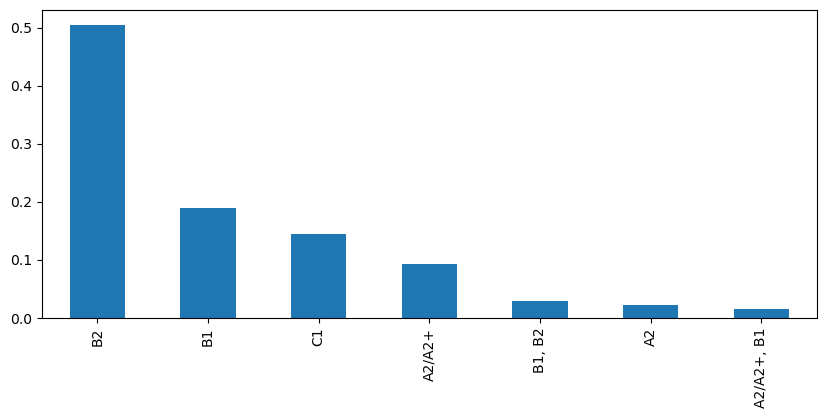

In [36]:
df['level'].value_counts(normalize=True).plot(kind='bar', figsize = (10, 4));

Объединим классы A2/A2+ и А2.

Данные классов "A2/A2+, B1" и "B1, B2" удалим, так как данных в них немного и они могут быть слишком "размытыми".

In [37]:
df.loc[df['level']=='A2/A2+', 'level'] = 'A2'
df = df.query('level != "A2/A2+, B1" and level != "B1, B2"')

Еще раз взглянем на классы.

In [38]:
df['level'].value_counts(normalize=True)

B2    0.529183
B1    0.198444
C1    0.151751
A2    0.120623
Name: level, dtype: float64

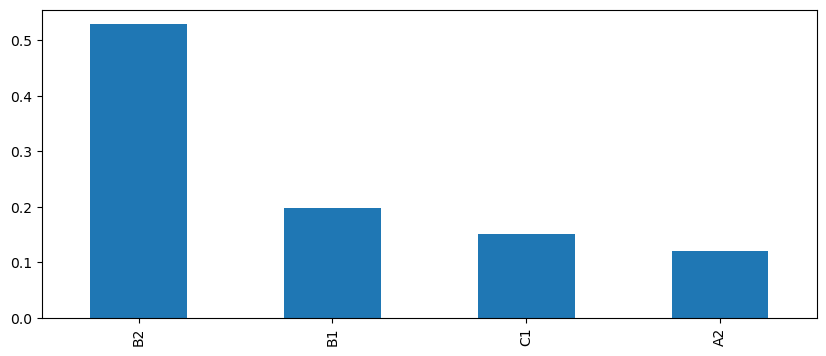

In [39]:
df['level'].value_counts(normalize=True).plot(kind='bar', figsize = (10, 4));

Проведем кодирование таргетов техникой OneHotEncoding

In [40]:
df = df.join(pd.get_dummies(df['level']))

Посмотрим на финальную таблицу с данными

In [41]:
df

,level,subs,A2,B1,B2,C1
0,B2,seek british nationalization royal highness pr...,0,0,1,0
1,B2,you re amazing woman ever meet think you re ra...,0,0,1,0
2,B2,harvey read I ve sutter three year guy one sli...,0,0,1,0
3,B2,car horn blare you re late nope second early...,0,0,1,0
4,B2,sure can not convince stay right time go home ...,0,0,1,0
...,...,...,...,...,...,...
263,A2,must blink pay careful attention everything se...,1,0,0,0
264,B1,music narrator everyone bear everyone bear gro...,0,1,0,0
266,B1,caregive feed clothing cleaning also understan...,0,1,0,0
267,B2,freud say love work work love that s well I m ...,0,0,1,0


# Разработка ML модели

Разделим данные на обучающие и тестовые

In [42]:
df_train, df_test = train_test_split (df, train_size = 0.7, stratify = df['level'], random_state=0)

In [43]:
count = CountVectorizer()
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

Выделим признаки и таргеты в отдельные переменные. Таргеты для каждого уровня английского языка будут отличаться, признаки будут одинаковые для всех.

In [44]:
levels = ['A2', 'B1', 'B2', 'C1']

X_train = df_train['subs']
y_train = [df_train[level] for level in levels]

X_test = df_test['subs']
y_test = [df_test[level] for level in levels]

Используем несколько классификаторов

In [45]:
clfs = [LogisticRegression, RandomForestClassifier, XGBClassifier]

Посмотрим на метрики различных моделей для каждого уровня английского языка

In [46]:
f1_metrics_df = pd.DataFrame()
f1_metrics = {}
accuracy_metrics_df = pd.DataFrame()
accuracy_metrics = {}
for y_trn, y_tst, lvl in zip(y_train, y_test, levels):
    for clf in clfs:
        if clf == LogisticRegression:
            model = Pipeline([('count', count),
                              ('clf', clf(random_state=0, max_iter=300))])
        else:
            model = Pipeline([('count', count),
                              ('clf', clf(random_state=0))])
        model.fit(X_train, y_trn)
        prediction = model.predict(X_test)
        f1_metrics[clf.__name__] = [f1_score(y_tst, prediction)]
        accuracy_metrics[clf.__name__] = [accuracy_score(y_tst, prediction)]
    f1_metrics_df = pd.concat([f1_metrics_df, pd.DataFrame(f1_metrics)])
    accuracy_metrics_df = pd.concat([accuracy_metrics_df, pd.DataFrame(accuracy_metrics)])
f1_metrics_df.index = levels
accuracy_metrics_df.index = levels
print ('\nAccuracy scores:')
display(accuracy_metrics_df)
print ('\nF1_scores:')
display(f1_metrics_df)


Accuracy scores:


,LogisticRegression,RandomForestClassifier,XGBClassifier
A2,0.910256,0.884615,0.884615
B1,0.794872,0.807692,0.833333
B2,0.756410,0.730769,0.653846
C1,0.961538,0.858974,0.961538



F1_scores:


,LogisticRegression,RandomForestClassifier,XGBClassifier
A2,0.461538,0.000000,0.181818
B1,0.384615,0.117647,0.434783
B2,0.771084,0.758621,0.649351
C1,0.869565,0.153846,0.857143


В связи с крайне низкой метрикой F1-меры исключим модель случайного леса из дальнейших расчетов.

Модель логистической регрессии показывает чуть лучшие результаты, при этом она лучше в классе B2, в котором более 50% данных.

In [47]:
clfs = [LogisticRegression, XGBClassifier]
accuracy_metrics_df = accuracy_metrics_df.drop('RandomForestClassifier', axis=1)
f1_metrics_df = f1_metrics_df.drop('RandomForestClassifier', axis=1)

Попробуем совместить предсказания моделей. 

Для этого подадим предсказания моделей в новую модель в качестве признаков. 

Обучим модели на обучающих данных и сделаем на них предсказания, затем данные предсказания будем использовать в качестве признаков и обучим новые модели. В эти модели уже подадим текущие предсказания.

In [48]:
f1_metrics_features_based_df = pd.DataFrame()
f1_metrics_features_based = {}
accuracy_metrics_features_based_df = pd.DataFrame()
accuracy_metrics_features_based = {}

for y_trn, y_tst, level,  in zip(y_train, y_test, levels):
    train_pred = pd.DataFrame()
    test_pred = pd.DataFrame()
    
    for clf in clfs:
        if clf == LogisticRegression:
            model = Pipeline([('count', count),
                              ('clf', clf(random_state=0, max_iter=300))])
        else:
            model = Pipeline([('count', count),
                              ('clf', clf(random_state=0))])
        model.fit(X_train, y_trn)
        train_pred[clf.__name__] = model.predict(X_train)
        test_pred[clf.__name__] = model.predict(X_test)
    
    for clf in clfs:
        model = clf(random_state=0)
        model.fit(train_pred, y_trn)
        prediction = model.predict(test_pred)
        f1_metrics_features_based[clf.__name__] = [f1_score(y_tst, prediction)]
        accuracy_metrics_features_based[clf.__name__] = [accuracy_score(y_tst, prediction)]
    f1_metrics_features_based_df = pd.concat([f1_metrics_features_based_df, 
                                              pd.DataFrame(f1_metrics_features_based)])
    accuracy_metrics_features_based_df = pd.concat([accuracy_metrics_features_based_df,
                                                    pd.DataFrame(accuracy_metrics_features_based)])

f1_metrics_features_based_df.index = levels
accuracy_metrics_features_based_df.index = levels

print ('\nF1 and accuracy scores for features_based models:')

f1_metrics_features_based_df.join(accuracy_metrics_features_based_df, how='left',
                                  lsuffix = "_F1_score", rsuffix = '_accuracy')


F1 and accuracy scores for features_based models:


,LogisticRegression_F1_score,XGBClassifier_F1_score,LogisticRegression_accuracy,XGBClassifier_accuracy
A2,0.200000,0.461538,0.897436,0.910256
B1,0.380952,0.384615,0.833333,0.794872
B2,0.747253,0.771084,0.705128,0.756410
C1,0.857143,0.869565,0.961538,0.961538


Выведем еще раз метрики изначальных моделей и сравним метрики моделей, основанных на изначальных данных с метриками моделей, основанных на предсказаниях.

In [49]:
print ('\nF1 and accuracy scores for models:')
f1_metrics_df.join(accuracy_metrics_df, how='left',
                   lsuffix = "_F1_score", rsuffix = '_accuracy')


F1 and accuracy scores for models:


,LogisticRegression_F1_score,XGBClassifier_F1_score,LogisticRegression_accuracy,XGBClassifier_accuracy
A2,0.461538,0.181818,0.910256,0.884615
B1,0.384615,0.434783,0.794872,0.833333
B2,0.771084,0.649351,0.756410,0.653846
C1,0.869565,0.857143,0.961538,0.961538


Можно заметить что в новых моделях лучшие метрики у классификатора XGBClassifier, однако они в точности совпадают с метриками модели логистической регрессии, обученной на начальных признаках.

Видимо новая модель подобрала такие веса, что ее результаты стали копировать результаты логистической регрессии, а значит в данном наборе моделей логистическая регрессия, обученная на начальных данных является оптимальной.

Создадим финальные модели.

Напишем класс, который объединит все модели в себе и будет выдавать предсказания.

На вход в качестве таргета он будет принимать уже непосредственно столбец, содержащий уровни английского языка.

In [50]:
X_train = df_train['subs']
y_train = df_train['level']

X_test = df_test['subs']
y_test = df_test['level']

In [51]:
class my_nlp_model():
    
    def __str__(self):
        return 'my_nlp_model'
    
    def __repr__(self):
        return self.__str__()
    
    def is_fitted(self):
        if not self.fitted:
            print ('Model is not fitted')
            return False
        else:
            return True
        
    def init_parameters(self, y):
        y_df = pd.DataFrame(y)
        y_df.columns = ['level']
        y_df = pd.get_dummies(y_df['level'])
        self.levels = [level for level in y_df.columns]
        self.models = [Pipeline([('count', CountVectorizer()),
                                 ('clf', LogisticRegression(random_state=0, max_iter=500))])
                       for level in self.levels]
        self.y_level_targets = [y_df[level] for level in y_df.columns]
        
    def fit(self, X, y):
        self.init_parameters(y)
        for y_train, model in zip(self.y_level_targets, self.models):
            model.fit(X, y_train)
        self.fitted = True
    
    def predict_proba(self, X):
        if self.is_fitted():
            pred_proba = pd.DataFrame()
            for model, level in zip (self.models, self.levels):
                pred_proba[level] = model.predict_proba(X)[:, 1]
            return pred_proba
    
    def predict(self, X):
        if self.is_fitted():
            return self.predict_proba(X).idxmax(axis=1)
    
    def score(self, X, y):
        if self.is_fitted():
            return accuracy_score(y, self.predict(X))
    
    def score_by_classes(self, X, y):
        if self.is_fitted():
            prediction = self.predict(X)
            score = pd.DataFrame()
            for level in self.levels:
                p = prediction.apply(lambda x: 1 if x==level else 0)
                y_leveled = y.apply(lambda x: 1 if x==level else 0)
                score = pd.concat([score, pd.DataFrame([[accuracy_score(y_leveled, p), f1_score(y_leveled, p)]], index=[level])])
            score.columns = ['accuracy', 'F1_score']        
            return score

In [52]:
model = my_nlp_model()

In [53]:
model.fit(X_train, y_train)

Выведем совокупную accuracy модели.

In [54]:
model.score(X_test, y_test)

0.6794871794871795

Выведем метрики в разрезе классов.

In [55]:
model.score_by_classes(X_test, y_test)

,accuracy,F1_score
A2,0.858974,0.352941
B1,0.769231,0.437500
B2,0.782051,0.800000
C1,0.948718,0.818182


Выведем предсказания модели.

In [56]:
model.predict(X_test)

0     A2
1     B1
2     B2
3     B2
4     B2
      ..
73    B2
74    B2
75    B1
76    B1
77    B2
Length: 78, dtype: object

Выведем вероятности принадлежности к классам, расчитанные моделью.

In [57]:
model.predict_proba(X_test)

,A2,B1,B2,C1
0,0.022866,0.013418,0.022187,2.041392e-07
1,0.179446,0.632660,0.025788,6.124967e-08
2,0.004741,0.052572,0.186850,1.609394e-05
3,0.000337,0.000052,0.844279,2.360433e-03
4,0.000108,0.000015,0.998795,4.939698e-05
...,...,...,...,...
73,0.000005,0.000006,0.999983,2.982581e-05
74,0.000040,0.000002,0.863346,5.696986e-02
75,0.001995,0.953965,0.000206,6.211590e-05
76,0.083612,0.418810,0.000007,3.319084e-05


# Заключение

В результате выполнения данного проекта разработана базовая модель NLP для определения уровня английского языка субтитров с совокупным accuracy 0.68 на тестовой выборке.

Возможные пути улучшения модели:
- добавление новых размеченных субтитров;
- выделение новых признаков из субтитров (например, средняя длина слова, среднее количество слов в минуту);
- добавление новых признаков извне (например словарей для определенных уровней языка);
- подбор гиперпараметров моделей и добавление новых моделей.